### Importy

In [128]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
import os

MODEL_DIR = "final_models"
MODEL_PATH = os.path.join(MODEL_DIR, "best_custom_model.pth")

os.makedirs(MODEL_DIR, exist_ok=True)

### Wczytanie danych

In [129]:
df = pd.read_csv("../data/final_data.csv", delimiter=';')
df.drop(columns=["id"], inplace=True)

### Dodatkowa analiza rozkładów i outlierów
Cel: Zidentyfikować i zrozumieć, które obserwacje ekstremalne (ceny > pewien próg) wypaczają odchylenie standardowe i R².

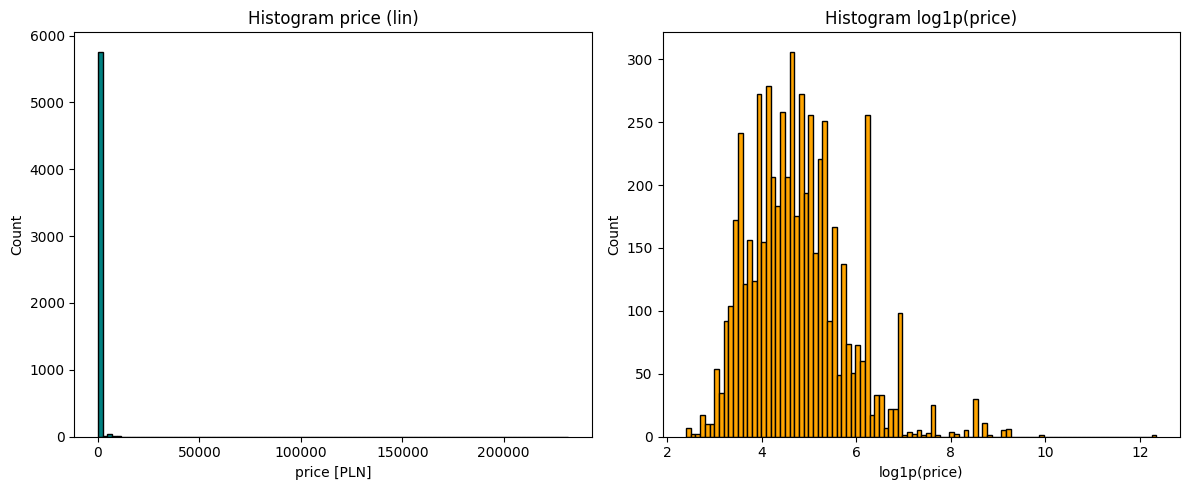

Price > 50 PLN: 76.47% obserwacji
Price > 100 PLN: 49.31% obserwacji
Price > 200 PLN: 23.62% obserwacji
Price > 300 PLN: 15.19% obserwacji
Price > 400 PLN: 11.72% obserwacji
Price > 500 PLN: 7.64% obserwacji
Price > 1000 PLN: 1.91% obserwacji
Price > 2000 PLN: 1.15% obserwacji
Price > 5000 PLN: 0.43% obserwacji


In [130]:
#Histogram cen w skali liniowej i logarytmicznej
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['price'], bins=100, color='teal', edgecolor='black')
plt.title('Histogram price (lin)')
plt.xlabel('price [PLN]')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(np.log1p(df['price']), bins=100, color='orange', edgecolor='black')
plt.title('Histogram log1p(price)')
plt.xlabel('log1p(price)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Proporcja ofert powyżej różnych progów
for threshold in [50, 100, 200, 300, 400, 500, 1000, 2000, 5000]:
    pct = (df['price'] > threshold).mean() * 100
    print(f"Price > {threshold} PLN: {pct:.2f}% obserwacji")

### Opcje dla outlierów: segmentacja lub ważenie
Cel: Zdecydować, czy tworzyć osobne podejście dla „premium” ofert, czy ważyć stratę tak, by model zwracał większą uwagę na drogie ogłoszenia

In [131]:
# Definiujemy próg premium – na przykład >1000 PLN
premium_threshold = 1550
cheap_threshold = 350

df['is_premium'] = (df['price'] > premium_threshold).astype(int)
df["is_cheap"] = (df["price"] <= cheap_threshold).astype(int)


print(f"Liczba premium ofert (>{premium_threshold} PLN):", df['is_premium'].sum(), "/", len(df))
print(f"Udział: {df['is_premium'].mean() * 100:.2f}%")

print(f"Liczba tanich ofert (<={cheap_threshold} PLN):", df['is_cheap'].sum(), "/", len(df))
print(f"Udział: {df['is_cheap'].mean() * 100:.2f}%")

Liczba premium ofert (>1550 PLN): 96 / 5826
Udział: 1.65%
Liczba tanich ofert (<=350 PLN): 5039 / 5826
Udział: 86.49%


### Potencjalnie przydatne cechy (feature engineering)

Odległość od centrum miasta

In [132]:
from math import radians, cos, sin, asin, sqrt

# Funkcja do obliczania odległości w km
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # km
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    return R * c

# Centrum Barcelony (Pl. Catalunya)
center_lat, center_lon = 41.387, 2.170

df["distance_to_center"] = df.apply(lambda row: haversine(row["latitude"], row["longitude"], center_lat, center_lon), axis=1)


Łączna liczba osób możliwych do zakwaterowania na metr łóżka/pokoju

In [133]:
df["people_per_bed"] = df["accommodates"] / (df["beds"] + 0.1)
df["people_per_bedroom"] = df["accommodates"] / (df["bedrooms"] + 0.1)

Liczba wszystkich udogodnień

In [134]:
amenity_cols = [col for col in df.columns if col.startswith("amenity_")]
df["num_amenities"] = df[amenity_cols].sum(axis=1)


Typ pokoju uproszczony

In [135]:
df["room_privacy_level"] = (
    df["room_type_Shared room"] * 0 +
    df["room_type_Private room"] * 1 +
    df["room_type_Entire home/apt"] * 2 +
    df["room_type_Hotel room"] * 2
)

Flagi dla niskiej / wysokiej liczby pokoi / łazienek

In [136]:
df["many_bedrooms"] = (df["bedrooms"] >= 3).astype(int)
df["few_bathrooms"] = (df["bathrooms_num"] <= 1).astype(int)


### Korelacje cech z log1p(price) i wybór Top 50
Wytypowanie tych cech, które rzeczywiście silnie korelują z ceną – tak, aby nie trenować sieci na wszystkich ~190 kolumnach, tylko skupić się na 50–60 najbardziej znaczących atrybutach. Dzięki temu:

- Mniejsza liczba wejściowych zmiennych da mniej parametrów w sieci → szybsze trenowanie i mniejsze ryzyko overfittingu.

- Sieć nie będzie “rozpraszać się” na cechy niemające realnego wpływu na cenę.

In [137]:
# Najpierw zapewniamy, że cena jest w logarytmie, bo rozkład jest mocno skośny:
price_log = np.log1p(df["price"])

# Obliczamy korelację bezwzględną każdej cechy z log1p(price)
# (pomijamy kolumny, których nie chcemy brać pod uwagę, np. 'id', samą 'price')
corrs = []
for col in df.columns:
    if col in ["id", "price"]:
        continue
    # bierzemy tylko cechy numeryczne (float lub int)
    if pd.api.types.is_numeric_dtype(df[col]):
        # obliczamy korelację Pearsona między df[col] a price_log
        c = np.corrcoef(df[col], price_log, rowvar=False)[0, 1]
        corrs.append((col, abs(c)))

# Sortujemy według wartości korelacji malejąco i wyświetlamy top 20
corrs_sorted = sorted(corrs, key=lambda x: x[1], reverse=True)

print("Top 50 cech o najwyższej korelacji z log1p(price):")
for col, cval in corrs_sorted[:50]:
    print(f"{col:<35} {cval:.3f}")

# Następnie wybieramy, powiedzmy, Top 50 najbardziej skorelowanych cech
top_k = [col for col, _ in corrs_sorted[:50]]
print(f"\nWybrano {len(top_k)} cech jako Top 50.")

Top 50 cech o najwyższej korelacji z log1p(price):
is_cheap                            0.710
accommodates                        0.530
property_type_Private room in rental unit 0.507
room_type_Private room              0.468
room_privacy_level                  0.461
is_premium                          0.454
room_type_Entire home/apt           0.449
property_type_Entire rental unit    0.404
bedrooms                            0.379
bathroom_type_shared                0.373
many_bedrooms                       0.329
bathroom_type_unknown               0.324
amenity_Dishwasher                  0.317
amenity_Hair dryer                  0.306
num_amenities                       0.292
instant_bookable                    0.292
amenity_Air conditioning            0.288
amenity_Lock on bedroom door        0.282
amenity_Crib                        0.274
beds                                0.261
amenity_Oven                        0.250
amenity_Hot water kettle            0.229
amenity_Toaster    

### Wybór danych do trenowania

Używamy top 50 najbardziej skorelowanych cech.

Kształt X: (5826, 50)
Kształt y: (5826,)


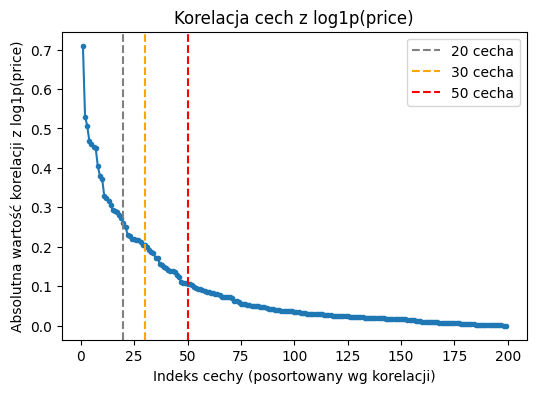

In [138]:
USE_TOP_K = True  # ustaw False, aby trenować na wszystkich cechach

# Target – zawsze log1p(price)
y = np.log1p(df["price"])

if USE_TOP_K:
    print("Używamy top 50 najbardziej skorelowanych cech.")
    X = df[top_k].copy()
else:
    print("Używamy wszystkich cech liczbowych.")
    excluded = ["id", "price", "is_premium"]  # dodaj więcej jeśli trzeba
    numeric_cols = [col for col in df.columns if col not in excluded and pd.api.types.is_numeric_dtype(df[col])]
    X = df[numeric_cols].copy()


# A target (y) to log1p(price) (ew. price, jeśli będziesz trenować na surowych wartościach)
y = price_log.copy()

# Sprawdźmy rozmiary:
print("\nKształt X:", X.shape)
print("Kształt y:", y.shape)

# Przygotuj listę samych wartości korelacji w kolejności malejącej:
corr_values = [c for _, c in corrs_sorted]

plt.figure(figsize=(6,4))
plt.plot(range(1, len(corr_values)+1), corr_values, marker='o', markersize=3)
plt.axvline(20, color='gray', linestyle='--', label='20 cecha')
plt.axvline(30, color='orange', linestyle='--', label='30 cecha')
plt.axvline(50, color='red', linestyle='--', label='50 cecha')
plt.xlabel('Indeks cechy (posortowany wg korelacji)')
plt.ylabel('Absolutna wartość korelacji z log1p(price)')
plt.title('Korelacja cech z log1p(price)')
plt.legend()
plt.show()


### Podział danych, standaryzacja i przygotowanie tensorów

In [139]:
# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standaryzacja cech
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Konwersja na tensory PyTorch
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [140]:
# Wagi odwrotnie proporcjonalne do ceny (logarytmicznie skalowane)
weights = 1.0 / (1.0 + torch.expm1(y_train_tensor))
weights = torch.clip(weights, 0.2, 3.0)

# Dodanie do datasetu z wagami
train_dataset = TensorDataset(X_train_tensor, y_train_tensor, weights)

In [141]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

### Prosty model sieci neuronowej

In [142]:
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.1),

            nn.Linear(128, 64),
            nn.LeakyReLU(),

            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)


input_dim = X_train.shape[1]
model = RegressionModel(input_dim)

### Trening modelu

In [143]:
num_epochs = 300  # <--- zmieniaj tutaj liczbę epok

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=num_epochs)

train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for X_batch, y_batch, w_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        eps = 1e-6  # by nie dzielić przez zero
        loss = (w_batch * ((outputs - y_batch).abs() / (y_batch.abs() + eps))).mean()
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_loss += loss.item() * X_batch.size(0)
    
    epoch_loss /= len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    if epoch % 10 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/300, Loss: 0.1295
Epoch 11/300, Loss: 0.0191
Epoch 21/300, Loss: 0.0177
Epoch 31/300, Loss: 0.0177
Epoch 41/300, Loss: 0.0161
Epoch 51/300, Loss: 0.0149
Epoch 61/300, Loss: 0.0146
Epoch 71/300, Loss: 0.0140
Epoch 81/300, Loss: 0.0129
Epoch 91/300, Loss: 0.0122
Epoch 101/300, Loss: 0.0115
Epoch 111/300, Loss: 0.0119
Epoch 121/300, Loss: 0.0108
Epoch 131/300, Loss: 0.0101
Epoch 141/300, Loss: 0.0101
Epoch 151/300, Loss: 0.0097
Epoch 161/300, Loss: 0.0091
Epoch 171/300, Loss: 0.0084
Epoch 181/300, Loss: 0.0083
Epoch 191/300, Loss: 0.0080
Epoch 201/300, Loss: 0.0074
Epoch 211/300, Loss: 0.0073
Epoch 221/300, Loss: 0.0068
Epoch 231/300, Loss: 0.0065
Epoch 241/300, Loss: 0.0063
Epoch 251/300, Loss: 0.0059
Epoch 261/300, Loss: 0.0060
Epoch 271/300, Loss: 0.0057
Epoch 281/300, Loss: 0.0056
Epoch 291/300, Loss: 0.0057
Epoch 300/300, Loss: 0.0055


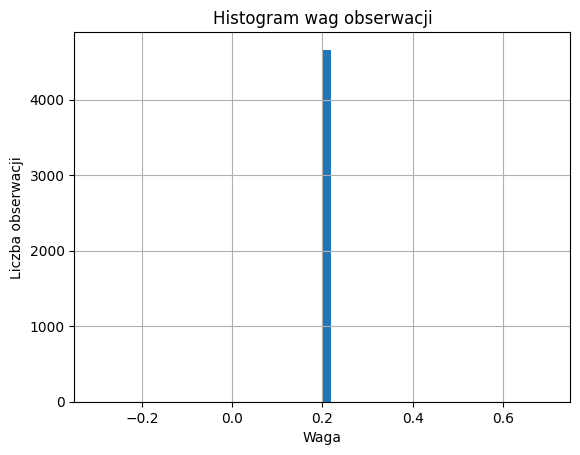

In [144]:
plt.hist(weights.numpy(), bins=50)
plt.title("Histogram wag obserwacji")
plt.xlabel("Waga")
plt.ylabel("Liczba obserwacji")
plt.grid(True)
plt.show()

### Wykres loss

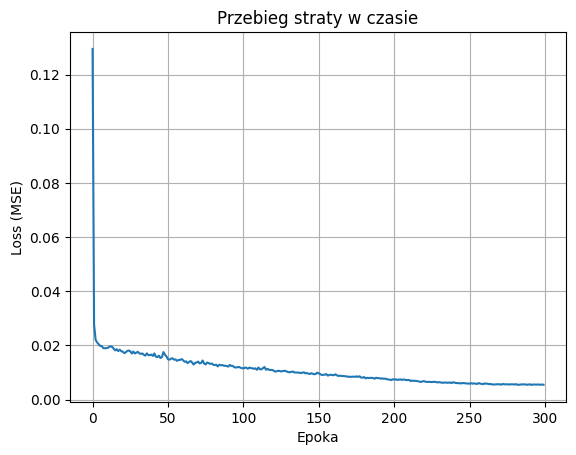

In [145]:
plt.plot(train_losses)
plt.xlabel("Epoka")
plt.ylabel("Loss (MSE)")
plt.title("Przebieg straty w czasie")
plt.grid(True)
plt.show()

### Ewaluacja metryk (MAE, RMSE, R²)

In [146]:
# Przełączenie modelu w tryb ewaluacji
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)

# Konwersja do NumPy
y_pred = y_pred_tensor.squeeze().numpy()
y_true = y_test_tensor.squeeze().numpy()

# --- Ewaluacja w skali log(price) ---
mae_log = mean_absolute_error(y_true, y_pred)
rmse_log = np.sqrt(mean_squared_error(y_true, y_pred))
r2_log = r2_score(y_true, y_pred)

print("Ewaluacja w skali log(price):")
print(f"MAE:  {mae_log:.4f}")
print(f"RMSE: {rmse_log:.4f}")
print(f"R²:   {r2_log:.4f}")

# --- Ewaluacja w skali rzeczywistej (PLN) ---
y_true_real = np.expm1(y_true)
y_pred_real = np.expm1(y_pred)

mae_real = mean_absolute_error(y_true_real, y_pred_real)
rmse_real = np.sqrt(mean_squared_error(y_true_real, y_pred_real))
r2_real = r2_score(y_true_real, y_pred_real)

print("\nEwaluacja w skali PLN:")
print(f"MAE:  {mae_real:.2f} PLN")
print(f"RMSE: {rmse_real:.2f} PLN")
print(f"R²:   {r2_real:.4f}")


Ewaluacja w skali log(price):
MAE:  0.3694
RMSE: 0.5051
R²:   0.7258

Ewaluacja w skali PLN:
MAE:  67.26 PLN
RMSE: 194.83 PLN
R²:   0.8821


### Zapisywanie lepszego modelu do pliku

In [147]:
# Funkcja do załadowania RMSE z poprzedniego modelu (jeśli istnieje)
def load_previous_rmse(path):
    if os.path.exists(path):
        checkpoint = torch.load(path, weights_only=False)
        return checkpoint.get("rmse", np.inf)
    return np.inf

# Pobierz RMSE z poprzedniego modelu
prev_rmse = load_previous_rmse(MODEL_PATH)

# Porównanie i zapis
if rmse_real < prev_rmse:
    print(f"Nowy model jest lepszy (RMSE {rmse_real:.4f} < {prev_rmse:.4f}) – zapisuję model.")
    torch.save({
        "model_state_dict": model.state_dict(),
        "scaler": scaler,
        "rmse": rmse_real,
        "r2": r2_real,
        "mae": mae_real,
        "use_top_k": USE_TOP_K,
        "input_dim": input_dim
    }, MODEL_PATH)
else:
    print(f"Model NIE został zapisany (RMSE {rmse_real:.4f} >= {prev_rmse:.4f})")

Nowy model jest lepszy (RMSE 194.8314 < inf) – zapisuję model.


### Wykres Predykcja vs Rzeczywistość

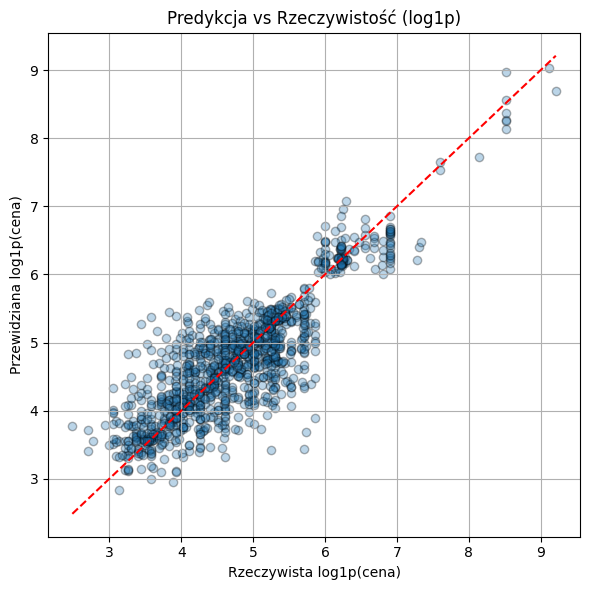

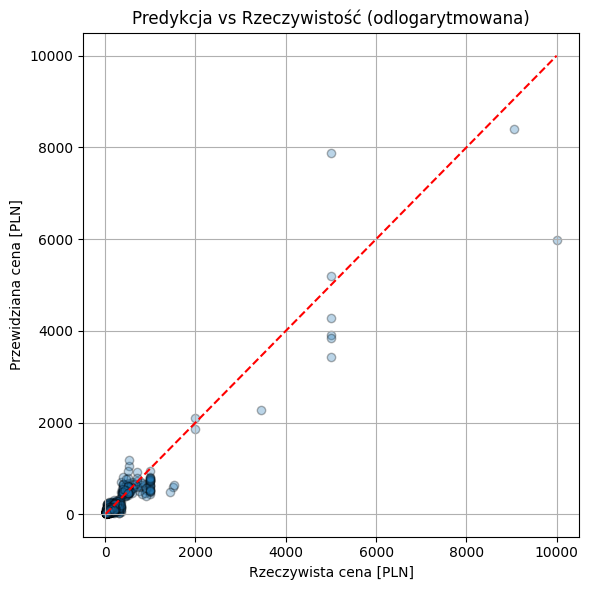

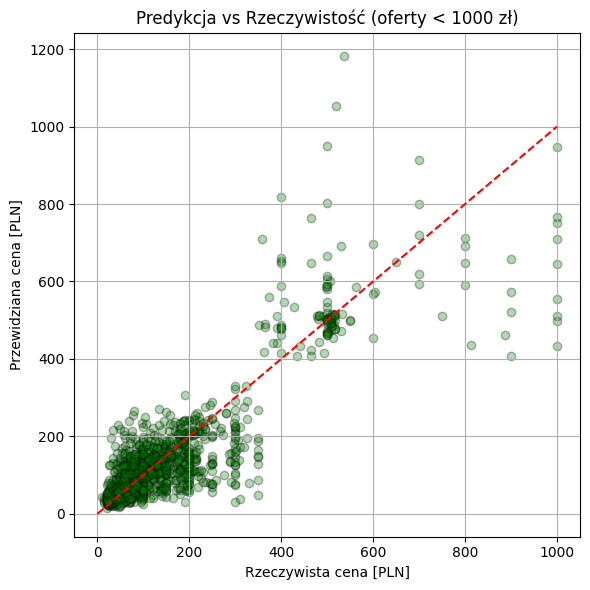

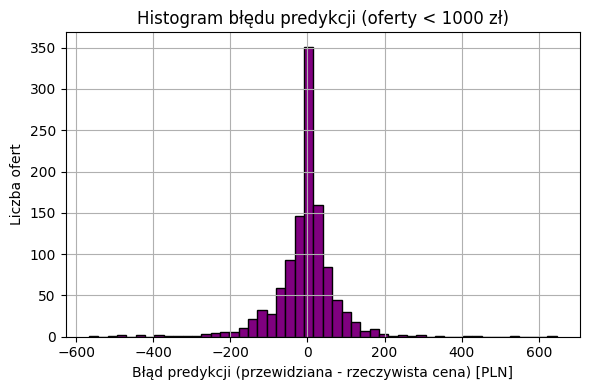

In [148]:
# Odlogarytmowanie predykcji i wartości rzeczywistych
y_true_exp = np.expm1(y_true)
y_pred_exp = np.expm1(y_pred)

# ===== 1. Wykres log1p(cena) =====
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.3, edgecolor='k')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
plt.xlabel("Rzeczywista log1p(cena)")
plt.ylabel("Przewidziana log1p(cena)")
plt.title("Predykcja vs Rzeczywistość (log1p)")
plt.grid(True)
plt.tight_layout()
plt.show()

# ===== 2. Wykres cena w PLN (odlogarytmowana) =====
plt.figure(figsize=(6, 6))
plt.scatter(y_true_exp, y_pred_exp, alpha=0.3, edgecolor='k')
plt.plot([min(y_true_exp), max(y_true_exp)], [min(y_true_exp), max(y_true_exp)], 'r--')
plt.xlabel("Rzeczywista cena [PLN]")
plt.ylabel("Przewidziana cena [PLN]")
plt.title("Predykcja vs Rzeczywistość (odlogarytmowana)")
plt.grid(True)
plt.tight_layout()
plt.show()

# ===== 3. Tylko oferty poniżej 1000 zł =====
mask = y_true_exp < 1000
plt.figure(figsize=(6, 6))
plt.scatter(y_true_exp[mask], y_pred_exp[mask], alpha=0.3, edgecolor='k', color='green')
plt.plot([0, 1000], [0, 1000], 'r--')
plt.xlabel("Rzeczywista cena [PLN]")
plt.ylabel("Przewidziana cena [PLN]")
plt.title("Predykcja vs Rzeczywistość (oferty < 1000 zł)")
plt.grid(True)
plt.tight_layout()
plt.show()

# ===== 4. Histogram błędów (tylko dla ofert < 1000 zł) =====
errors = y_pred_exp - y_true_exp
plt.figure(figsize=(6, 4))
plt.hist(errors[mask], bins=50, color='purple', edgecolor='black')
plt.title("Histogram błędu predykcji (oferty < 1000 zł)")
plt.xlabel("Błąd predykcji (przewidziana - rzeczywista cena) [PLN]")
plt.ylabel("Liczba ofert")
plt.grid(True)
plt.tight_layout()
plt.show()
